DECISION TREE: Custom vs Sklearn

 Training Custom Tree...
Custom Tree Accuracy: 0.8400

 Training Sklearn Tree...
Sklearn Tree Accuracy: 0.7800

Difference: 0.0600

 Saved: decision_boundaries_entropy_with_pruning.png

OVERFITTING DEMONSTRATION
 Saved: tree_overfitting.png

Optimal Depth: 6
Best Test Accuracy: 0.8600

FEATURE IMPORTANCE
Feature    Custom       Sklearn
--------------------------------------------------
Feature 0       0.0385      0.0085
Feature 1       0.3077      0.3050
Feature 2       0.3846      0.3078
Feature 3       0.2692      0.3787

 Decision Tree implementation complete!
 Key Takeaways:
   • Trees split based on information gain (Gini/Entropy)
   • Deeper trees → more complex → overfit easily
   • Feature importance = frequency of feature in splits


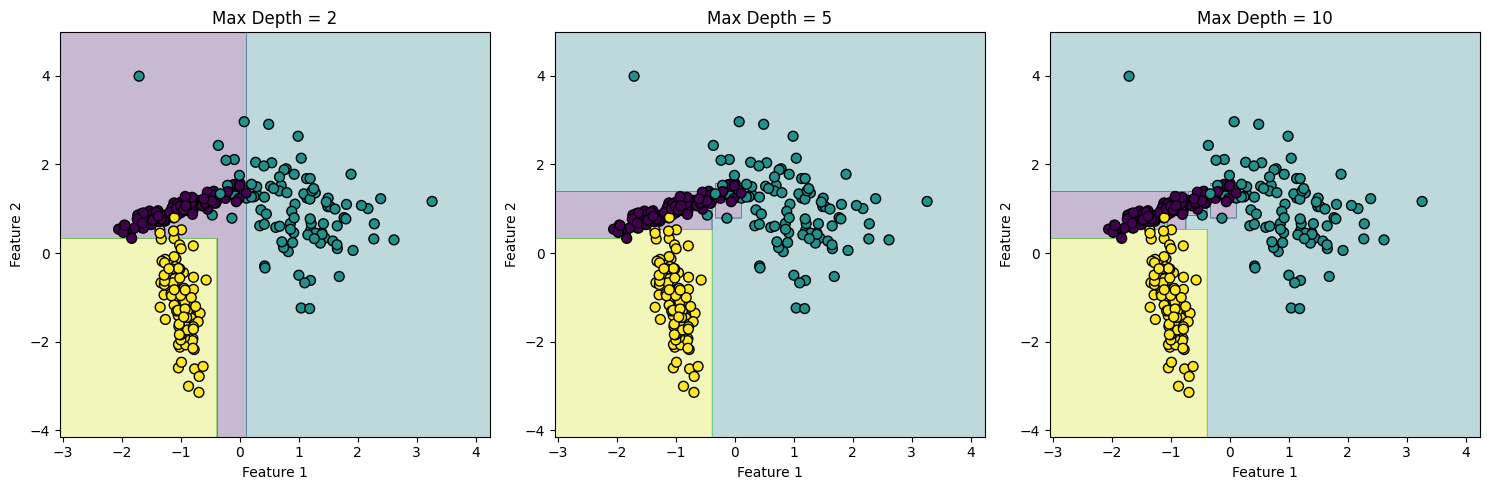

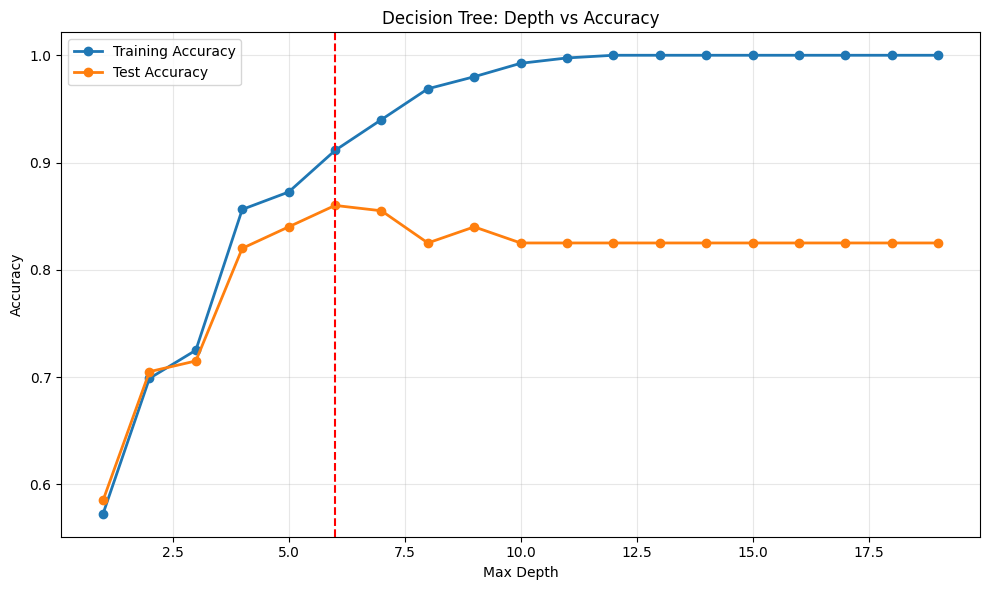

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


# DECISION TREE FROM SCRATCH (CART Algorithm)


class Node:
    """Decision Tree Node"""
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature        # Feature index to split on
        self.threshold = threshold    # Threshold value
        self.left = left              # Left subtree
        self.right = right            # Right subtree
        self.value = value            # Leaf value (for predictions)
        

class DecisionTreeScratch:
    """CART Decision Tree Implementation"""
    
    def __init__(self, max_depth=10, min_samples_split=2,min_impurity_decrease=1e-7):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
        self.min_impurity_decrease=min_impurity_decrease
    
    def _gini_impurity(self, y):
        """Calculate Gini impurity: 1 - sum(p_i^2)"""
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)
    
    def _entropy(self, y):
        """Calculate entropy: -sum(p_i * log(p_i))"""
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-10))
    
    def _information_gain(self, parent, left_child, right_child):
        """Calculate information gain from a split"""
        n = len(parent)
        n_left, n_right = len(left_child), len(right_child)
        
        # Weighted average of child impurities
        e_parent = self._gini_impurity(parent)
        e_children = (n_left / n) * self._gini_impurity(left_child) + \
                     (n_right / n) * self._gini_impurity(right_child)
        
        return e_parent - e_children
    

    def _information_gain_entropy(self, parent, left_child, right_child):
        """Calculate information gain from a split"""
        n = len(parent)
        n_left, n_right = len(left_child), len(right_child)
        
        # Weighted average of child impurities
        e_parent = self._entropy(parent)
        e_children = (n_left / n) * self._entropy(left_child) + \
                     (n_right / n) * self._entropy(right_child)
        
        return e_parent - e_children
    
    def _best_split(self, X, y):
        """Find the best feature and threshold to split on"""
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        n_features = X.shape[1]
        
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            
            for threshold in thresholds:
                # Split data
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                # Calculate information gain
                gain = self._information_gain_entropy(y, y[left_mask], y[right_mask])
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _build_tree(self, X, y, depth=0):
        """Recursively build the decision tree"""
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Stopping criteria
        if depth >= self.max_depth or n_samples < self.min_samples_split or n_classes == 1 :
            # Create leaf node with majority class
            leaf_value = np.argmax(np.bincount(y))
            return Node(value=leaf_value)
        
        # Find best split
        best_feature, best_threshold, best_gain = self._best_split(X, y)
        
        if best_gain < self.min_impurity_decrease:
            leaf_value = np.argmax(np.bincount(y))
            return Node(value=leaf_value)
        
        # Split data
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        # Recursively build left and right subtrees
        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return Node(best_feature, best_threshold, left_subtree, right_subtree)
    
    def fit(self, X, y):
        """Train the decision tree"""
        self.root = self._build_tree(X, y)
        return self
    
    def _predict_sample(self, x, node):
        """Predict a single sample by traversing the tree"""
        if node.value is not None:
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)
    
    def predict(self, X):
        """Predict multiple samples"""
        return np.array([self._predict_sample(x, self.root) for x in X])
    
    def score(self, X, y):
        """Calculate accuracy"""
        predictions = self.predict(X)
        return np.mean(predictions == y)

# ==========================================
# TEST CUSTOM TREE vs SKLEARN
# ==========================================

print("="*50)
print("DECISION TREE: Custom vs Sklearn")
print("="*50)

# Load data
X, y = make_classification(n_samples=1000, n_features=4, n_informative=3,
                          n_redundant=0, n_classes=3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Custom implementation
print("\n Training Custom Tree...")
custom_tree = DecisionTreeScratch(max_depth=5, min_samples_split=2)
custom_tree.fit(X_train, y_train)
custom_score = custom_tree.score(X_test, y_test)
print(f"Custom Tree Accuracy: {custom_score:.4f}")

# Sklearn implementation
print("\n Training Sklearn Tree...")
sklearn_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=2, random_state=42)
sklearn_tree.fit(X_train, y_train)
sklearn_score = sklearn_tree.score(X_test, y_test)
print(f"Sklearn Tree Accuracy: {sklearn_score:.4f}")

print(f"\nDifference: {abs(custom_score - sklearn_score):.4f}")


# VISUALIZE DECISION BOUNDARIES


def plot_decision_boundary(X, y, model, title):
    """Plot 2D decision boundary"""
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict on mesh
    if hasattr(model, 'predict'):
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='viridis', s=50)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

# Use 2D data for visualization
X_2d, y_2d = make_classification(n_samples=300, n_features=2, n_informative=2,
                                  n_redundant=0, n_clusters_per_class=1,
                                  n_classes=3, random_state=42)

plt.figure(figsize=(15, 5))

for i, depth in enumerate([2, 5, 10]):
    plt.subplot(1, 3, i + 1)
    tree = DecisionTreeScratch(max_depth=depth)
    tree.fit(X_2d, y_2d)
    plot_decision_boundary(X_2d, y_2d, tree, f'Max Depth = {depth}')

plt.tight_layout()
plt.savefig('decision_boundaries.png', dpi=100, bbox_inches='tight')
print("\n Saved: decision_boundaries_entropy_with_pruning.png")


# UNDERSTANDING OVERFITTING IN TREES


print("\n" + "="*50)
print("OVERFITTING DEMONSTRATION")
print("="*50)

depths = range(1, 20)
train_scores = []
test_scores = []

for depth in depths:
    tree = DecisionTreeScratch(max_depth=depth)
    tree.fit(X_train, y_train)
    
    train_scores.append(tree.score(X_train, y_train))
    test_scores.append(tree.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, 'o-', label='Training Accuracy', linewidth=2)
plt.plot(depths, test_scores, 'o-', label='Test Accuracy', linewidth=2)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree: Depth vs Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=np.argmax(test_scores) + 1, color='r', linestyle='--', 
            label=f'Optimal Depth = {np.argmax(test_scores) + 1}')
plt.tight_layout()
plt.savefig('tree_overfitting.png', dpi=100, bbox_inches='tight')
print(" Saved: tree_overfitting.png")

print(f"\nOptimal Depth: {np.argmax(test_scores) + 1}")
print(f"Best Test Accuracy: {max(test_scores):.4f}")


# FEATURE IMPORTANCE (Manual Calculation)


def calculate_feature_importance(tree, n_features):
    """Calculate feature importance by counting splits"""
    importances = np.zeros(n_features)
    
    def traverse(node):
        if node.value is not None:
            return
        importances[node.feature] += 1
        if node.left:
            traverse(node.left)
        if node.right:
            traverse(node.right)
    
    traverse(tree.root)
    return importances / importances.sum() if importances.sum() > 0 else importances

custom_importance = calculate_feature_importance(custom_tree, X.shape[1])
sklearn_importance = sklearn_tree.feature_importances_

print("\n" + "="*50)
print("FEATURE IMPORTANCE")
print("="*50)
print(f"{'Feature':<10} {'Custom':<12} {'Sklearn'}")
print("-"*50)
for i in range(len(custom_importance)):
    print(f"Feature {i:<3} {custom_importance[i]:>10.4f}  {sklearn_importance[i]:>10.4f}")

print("\n Decision Tree implementation complete!")
print(" Key Takeaways:")
print("   • Trees split based on information gain (Gini/Entropy)")
print("   • Deeper trees → more complex → overfit easily")
print("   • Feature importance = frequency of feature in splits")